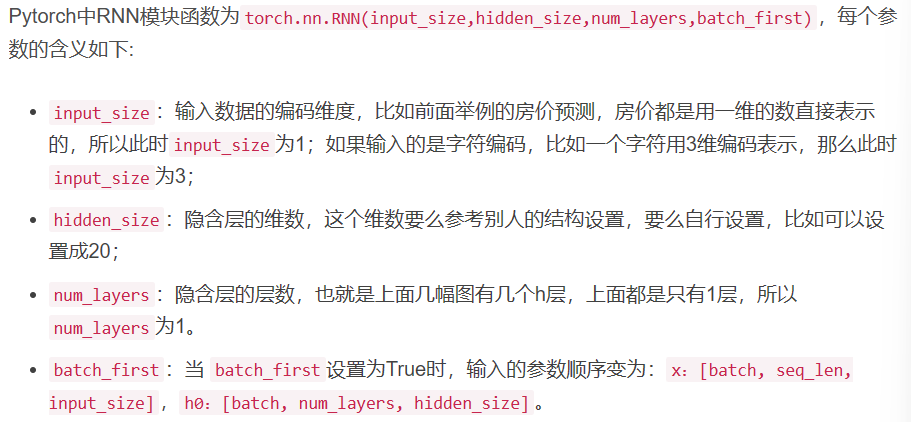
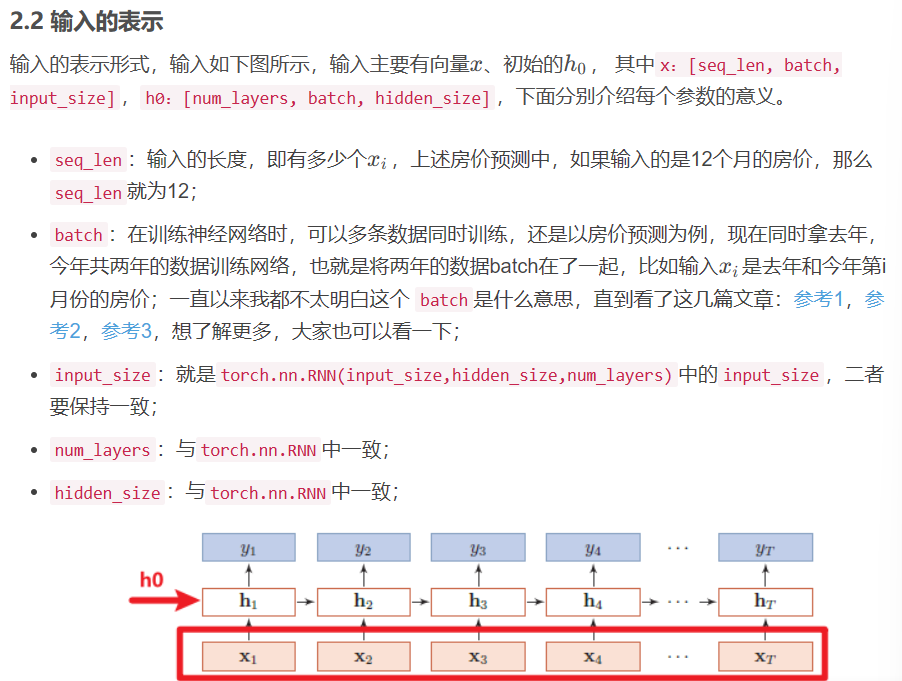

model:
 Net(
  (rnn): RNN(3, 16, batch_first=True)
  (linear): Linear(in_features=16, out_features=3, bias=True)
)
model parameters: <generator object Module.parameters at 0x0000020975467E40>
Iteration:0 loss 0.19578582048416138
Iteration:100 loss 0.027875704690814018
Iteration:200 loss 0.024404536932706833
Iteration:300 loss 0.020790688693523407
Iteration:400 loss 0.017148595303297043
Iteration:500 loss 0.019153647124767303
Iteration:600 loss 0.017056960612535477
Iteration:700 loss 0.012183167971670628
Iteration:800 loss 0.007979407906532288
Iteration:900 loss 0.003750699106603861
Iteration:1000 loss 0.0037349124904721975
Iteration:1100 loss 0.0031440381426364183
Iteration:1200 loss 0.003304246347397566
Iteration:1300 loss 0.0013158806832507253
Iteration:1400 loss 0.005581352394074202
Iteration:1500 loss 0.007949979044497013
Iteration:1600 loss 0.0009595718584023416
Iteration:1700 loss 0.008366039954125881
Iteration:1800 loss 0.0019790891092270613
Iteration:1900 loss 0.001083930954337

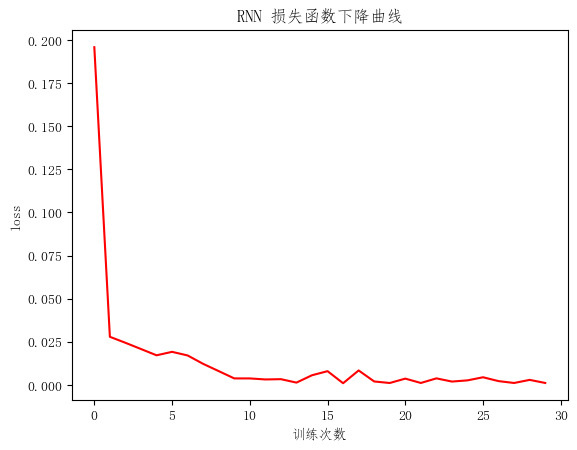

pred1.shape: torch.Size([1, 10, 3])
pred2.shape: torch.Size([1, 10, 3])


C:\Users\15295\AppData\Local\Temp\ipykernel_20136\3840755623.py:115: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(fig)


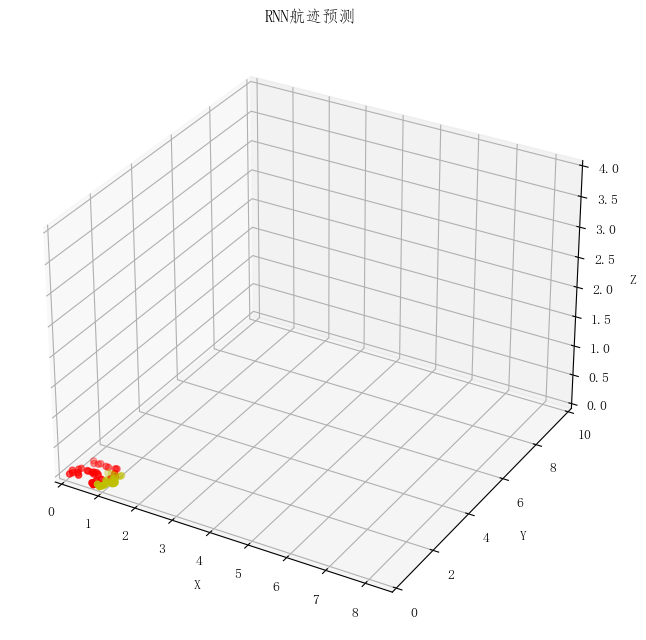

In [11]:
import torch 
import datetime
import numpy as np
import torch.nn as nn
import torch.optim as optim 
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import mpl
from sklearn.preprocessing import MinMaxScaler
mpl.rcParams['font.sans-serif']=['FangSong']
mpl.rcParams['axes.unicode_minus']=False

#############设置全局变量############

num_time_steps=16   #训练时间窗的步长
input_size=3        #输入数据维度
hidden_size=16      #隐含层维度
output_size=3       #输出维度
num_layers=1        #隐藏层层数
lr=0.01             #学习率


##############定义RNN#############
class Net(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers):
        super(Net,self).__init__()
        
        self.rnn=nn.RNN(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True)
        
        for p in self.rnn.parameters():
            nn.init.normal_(p,mean=0.0,std=0.001)
            
        self.linear=nn.Linear(hidden_size,output_size)
        
        
    def forward(self,x,hidden_prev):
        '''
         x：一次性输入所有样本所有时刻的值(batch,seq_len,feature_len)
        hidden_prev：第一个时刻空间上所有层的记忆单元(batch, num_layer, hidden_len)
        输出out(batch,seq_len,hidden_len) 和 hidden_prev(batch,num_layer,hidden_len)
        '''
        out,hiddem_prev=self.rnn(x,hidden_prev)

        #[b,seq,h]
        out=out.view(-1,hidden_size)
        out=self.linear(out)
        out=out.unsqueeze(dim=0)
        return out,hidden_prev
#初始化训练集
def getdata():
    x1=np.linspace(1,10,30).reshape(30,1)
    y1=(np.zeros_like(x1)+2)+np.random.rand(30,1)*0.1
    z1=(np.zeros_like(x1)+2).reshape(30,1)
    tr1=np.concatenate((x1,y1,z1),axis=1)
    mm=MinMaxScaler()
    data=mm.fit_transform(tr1)
    return data


def train_RNN(data):
    model=Net(input_size,hidden_size,num_layers)
    print('model:\n',model)
    print('model parameters:',model.parameters())
    criterion=nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr)
    #初始化h
    hidden_prev=torch.zeros(1,1,hidden_size)
    l=[]
    for iter in range(3000):
        loss=0
        start=np.random.randint(10,size=1)[0]
        end=start+15
        x=torch.tensor(data[start:end]).float().view(1,num_time_steps-1,3)
        y=torch.tensor(data[start+5:end+5]).float().view(1,num_time_steps-1,3)

        output,hidden_prev=model(x,hidden_prev)
        hidden_prev=hidden_prev.detach()

        loss=criterion(output,y)
        model.zero_grad()
        loss.backward()
        optimizer.step()

        if iter % 100 ==0:
            print('Iteration:{} loss {}'.format(iter,loss.item()))
            l.append(loss.item())

    plt.plot(l,'r')
    plt.xlabel('训练次数')
    plt.ylabel('loss')
    plt.title('RNN 损失函数下降曲线')
    print('mode parameters:',model.parameters())

    return hidden_prev,model


def RNN_pre(model,data,hidden_prev):
    data_test=data[19:29]
    data_test=torch.tensor(np.expand_dims(data_test,axis=0),dtype=torch.float32)#在0维度上增加一个维度
    pred1,h1=model(data_test,hidden_prev)
    print('pred1.shape:',pred1.shape)
    pred2,h2=model(pred1,hidden_prev)
    print('pred2.shape:',pred2.shape)
    pred1=pred1.detach().numpy().reshape(10,3)
    pred2=pred2.detach().numpy().reshape(10,3)
    predictions=np.concatenate((pred1,pred2),axis=0)
    


    fig=plt.figure(figsize=(9,6))
    ax=Axes3D(fig)
    ax.scatter3D(data[:,0],data[:,1],data[:,2],c='red')
    ax.scatter3D(predictions[:,0],predictions[:,1],predictions[:,2],c='y')
    ax.set_xlabel('X')
    ax.set_xlim(0,8.5)
    ax.set_ylabel('Y')
    ax.set_ylim(0,10)
    ax.set_zlabel('Z')
    ax.set_zlim(0,4)
    plt.title('RNN航迹预测')
    plt.show()


def main():
    data=getdata()
    start=datetime.datetime.now()
    hidden_pre,model=train_RNN(data)
    end=datetime.datetime.now()
    print('The training time:%s'%str(end-start))
    plt.show()
    RNN_pre(model,data,hidden_pre)
if __name__ == '__main__':
    main() 